In [1]:
import json

import numpy as np

with open("./data/coords.json", "r") as f:
    coords = np.array(json.loads(f.read())['coords'])

/tmp/ipykernel_64317/748110839.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ls = algo.labels_.astype(np.int)


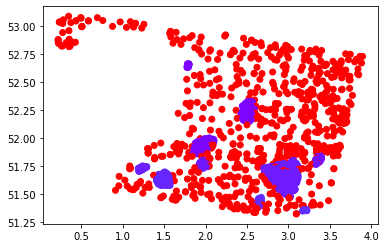

             X          Y  cluster
0     0.346406  53.085610       -1
1     0.491556  53.072988       -1
2     0.693504  53.072988       -1
3     0.495763  53.070884       -1
4     0.495763  53.068781       -1
...        ...        ...      ...
1807  2.599392  51.339598       -1
1808  2.725609  51.339598       -1
1809  2.601495  51.337495       -1
1810  3.095848  51.326977       -1
1811  3.095848  51.324873       -1

[1812 rows x 3 columns]


In [5]:
from sklearn import cluster
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt

colors = cm.rainbow(np.linspace(0, 1, 200))


def apply(xx, algo):
    algo.fit(xx)
    ls = algo.labels_.astype(np.int)
    plt.scatter(xx[:, 0], xx[:, 1], color=colors[ls])
    plt.show()
    return ls


df = pd.DataFrame(coords)
x = df.to_numpy()
labels = apply(x, cluster.DBSCAN(eps=.03, min_samples=10))

cluster_map = pd.DataFrame()
cluster_map['X'] = x[:, 0]
cluster_map['Y'] = x[:, 1]
cluster_map['cluster'] = labels

print(cluster_map)

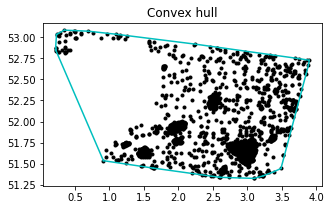

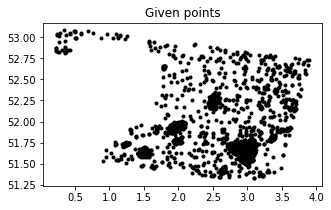

In [19]:
from scipy import spatial

hull = spatial.ConvexHull(coords)
for plot_id in (2, 1):
    fig, ax = plt.subplots(ncols=1, figsize=(5, 3))
    ax.plot(coords[:, 0], coords[:, 1], '.', color='k')
    if plot_id == 1:
        ax.set_title('Given points')
    else:
        ax.set_title('Convex hull')
        for simplex in hull.simplices:
            ax.plot(coords[simplex, 0], coords[simplex, 1], 'c')
    plt.show()

In [10]:
from scipy import spatial

column_values = cluster_map["cluster"].values
clusters = np.unique(column_values)
shapes = []
for cluster in clusters:
    if cluster_map[cluster_map.cluster == cluster].shape[0] <= 10:
        continue
    if cluster == -1:
        continue

    # extract points from dataframe
    pts = []
    for row in cluster_map[cluster_map.cluster == cluster].iterrows():
        pts.append((row[1]["X"], row[1]["Y"]))
    pts = np.array(pts)

    # create convex hull
    hull = spatial.ConvexHull(pts)
    border_pts = []
    for simplex in hull.simplices:
        border_pts.append((pts[simplex, 0], pts[simplex, 1]))

    # append shape
    shapes.append([(r[0], r[1]) for r in pts[hull.vertices]])

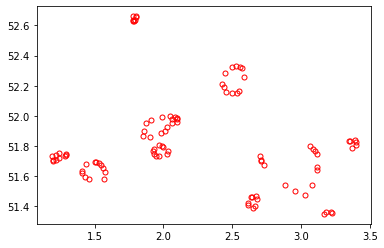

In [12]:
for shape in shapes:
    plt.plot([v[0] for v in shape], [v[1] for v in shape], 'o', mec='r', color='none', lw=1, markersize=5)

In [16]:
import geopandas as gpd
from shapely.geometry import Polygon

polygons = []
for shape in shapes:
    polygons.append(Polygon(shape))

results = gpd.GeoDataFrame({
    'geometry': polygons
})

results.crs = 'epsg:4326'
results.to_file("result.shp")